In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

# num of max poisoning points, max 20% poison rate
poison_ct = 328
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  328  Train count:  1319  Test count:  165  Proportion of poisoning:  0.19914996964177292


# Inverse Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Iteration  0 
Objective Value:  0.042382641480767744  Change:  0.042382641480767744
Validation MSE  0.005419296581047362 
Test MSE  0.007404175517337051
 
Iteration  1
Objective Value: 0.04809068727505346  Difference:  0.0057080457942857155
 
Iteration  2
Objective Value: 0.048748991664487984  Difference:  0.0006583043894345247
 
Iteration  3
Objective Value: 0.04930331473038143  Difference:  0.0005543230658934459
 
Iteration  4
Objective Value: 0.0494223311236254  Difference:  0.00011901639324397167
 
Iteration  5
Objective Value: 0.04917628560216948  Difference:  -0.0002460455214559204
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.049078700767121425  Difference:  -0.00034363035650397666
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.0491407611356038  Difference:  -0.0002815699880216044
NO PROGRESS MADE!
 
Iteration  8
Objective Value: 0.0

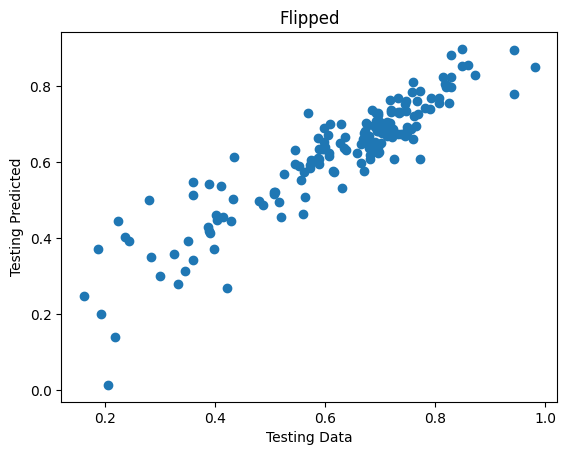

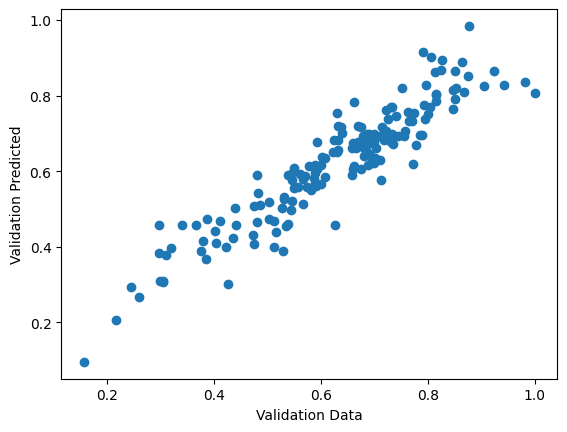

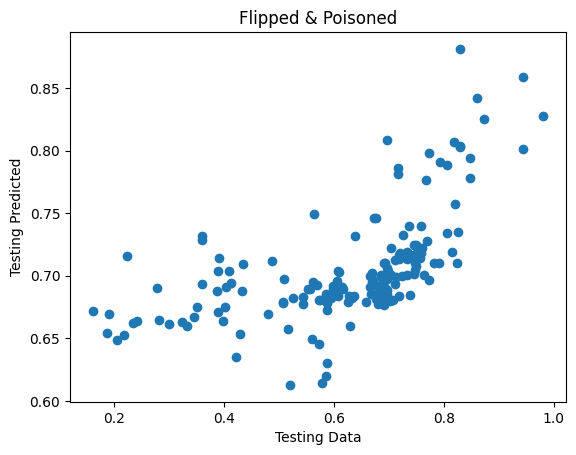

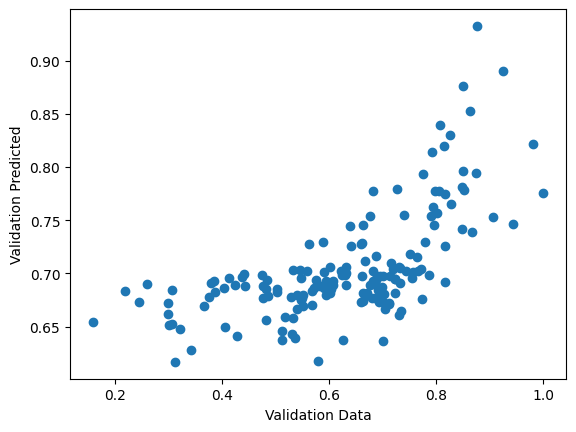


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037249733701270695 
 Test MSE: 0.004722250058956812

After Flipping & Poisoning:
 Validation MSE:  0.024462059330560122 
 Test MSE: 0.028441567198553352


In [3]:
# define parameters for poisoner
eta = 0.02 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 10 # minimum iterations
stop2 = 30 # maximum iterations
stop3 = 10 # maximum no progress count, if exceeds, give up and stop
decrease_rate = 0.75 # decrease rate of eta if no progress made

# flip the data
x_flip, y_flip = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, lam = poiser.learn_model(np.concatenate((poi_train_x, x_flip), axis=0), poi_train_y + y_flip, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_flip = np.matrix(x_flip)
y_flip = y_flip[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = 0.2*(i + 1)*total_prop
    sample_amt = int(train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_flip[:sample_amt,:]
    current_y_pois = y_flip[:sample_amt]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  54  ****
*****************************
Iteration  0 
Objective Value:  0.04475789442751075  Change:  0.04475789442751075
Validation MSE  0.004972149848326596 
Test MSE  0.005845884587278626
 
Iteration  1
Objective Value: 0.10767607875993482  Difference:  0.06291818433242408
 
Iteration  2
Objective Value: 0.0965288847521675  Difference:  -0.011147194007767314
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.09940421399738643  Difference:  -0.00827186476254839
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.10155529148927446  Difference:  -0.006120787270660358
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.10316450814752921  Difference:  -0.004511570612405605
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.10435861699165075  Difference:  -0.003317461768284069
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.10523057848207426  Difference:  -0.0024455002778605572
NO PROGRE

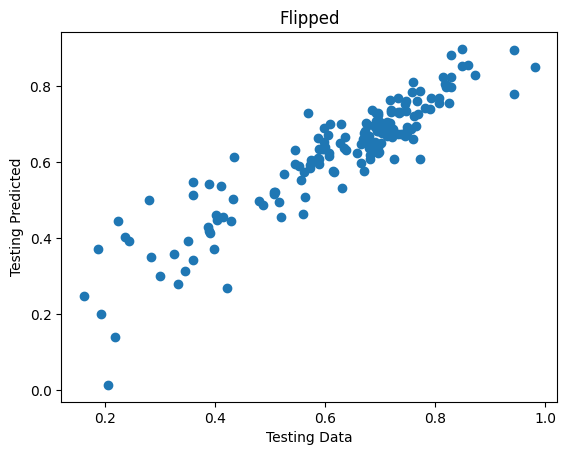

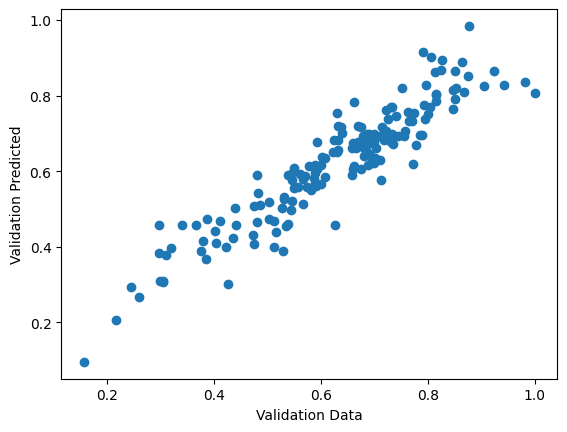

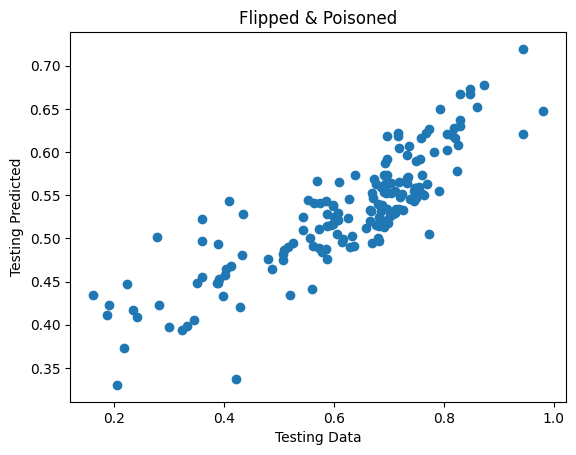

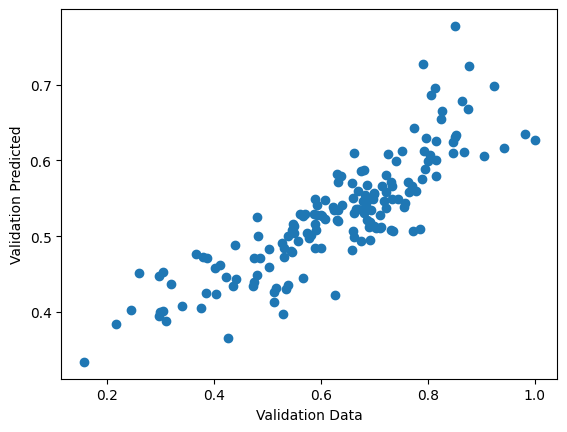


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037249733701270695 
 Test MSE: 0.004722250058956812

After Flipping & Poisoning:
 Validation MSE:  0.02146675394413754 
 Test MSE: 0.021879518758833417


In [4]:
# flip the data
x_flip, y_flip = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, lam = poiser.learn_model(np.concatenate((poi_train_x, x_flip), axis=0), poi_train_y + y_flip, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_flip = np.matrix(x_flip)
y_flip = y_flip[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = 0.2*(i + 1)*total_prop
    sample_amt = int(train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_flip[:sample_amt,:]
    current_y_pois = y_flip[:sample_amt]
    # Get the current time before running the code
    start_time = datetime.datetime.now()
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    # Get the current time after running the code
    end_time = datetime.datetime.now()
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    # Calculate the difference between the start and end times
    time_diff = end_time - start_time
    print("Total running time (seconds):", time_diff.total_seconds())
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])